# 導入相關套件

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pytrends.request import TrendReq
from datetime import datetime, timedelta
from tqdm import tqdm
import time

# 搜尋目標股池

In [3]:
###最近一次0050持股
pool=pd.read_excel('五月二十三日台灣五十倉位.xlsx')
pool['商品代碼']=pool['商品代碼'].astype(str)
true_columns =pool['商品代碼'].values.tolist()

# 辨認資料開始日

In [4]:
bench_mark=pd.read_pickle('基準.pkl')

In [5]:
###最早開始日為2004-01-01
df = bench_mark[true_columns]
start_dates = df.apply(lambda col: col.first_valid_index())
last_date = bench_mark.index.max()
end_dates = pd.Series(last_date, index=df.columns)
date_ranges = pd.DataFrame({'start_date': start_dates, 'end_date': end_dates})
date_ranges.index.name = 'keyword'
date_ranges.reset_index(inplace=True)

# 增加搜尋成功率

In [6]:
industry_data=pd.read_excel('TSE_industry.xlsx')

In [7]:
# 1. 確保證券代碼是字串
#date_ranges['keyword'] = date_ranges['keyword'].astype(str)
industry_data['證券代碼'] = industry_data['證券代碼'].astype(str)
merged_df = date_ranges.merge(industry_data[['證券代碼', '公司名稱', 'TSE新產業名']],
                           left_on='keyword',
                           right_on='證券代碼',
                           how='left')
merged_df = merged_df[['keyword', '公司名稱', 'TSE新產業名', 'start_date', 'end_date']]
merged_df['symbol']= merged_df['keyword']
merged_df['keyword'] = merged_df.apply(
    lambda row: f"{row['公司名稱']} ({row['keyword']})" if pd.notnull(row['公司名稱']) else row['keyword'],
    axis=1)
merged_df = merged_df[['keyword', '公司名稱','symbol', 'TSE新產業名', 'start_date', 'end_date']]

# 工作排程

In [8]:
top_cap_list=merged_df['keyword'].values.tolist()

In [9]:
work_list=merged_df.set_index('keyword')

In [ ]:
total_symbols = len(top_cap_list)
print(f"總共有 {total_symbols} 檔股票曾進入目標股池")
from math import ceil
chunk_size = ceil(total_symbols / 10)
top_cap_chunks = [top_cap_list[i:i+chunk_size] for i in range(0, total_symbols, chunk_size)]
for idx, chunk in enumerate(top_cap_chunks):
    print(f"第 {idx+1} 組，共 {len(chunk)}")

# google trend 抓取資料

In [ ]:
# === 切分時間區段 ===
def get_time_ranges(start, end, years=5):
    start_dt = datetime.strptime(start, '%Y-%m-%d')
    end_dt = datetime.strptime(end, '%Y-%m-%d')
    ranges = []
    current = start_dt
    while current < end_dt:
        next_date = min(current + timedelta(days=365 * years), end_dt)
        ranges.append((current.strftime('%Y-%m-%d'), next_date.strftime('%Y-%m-%d')))
        current = next_date
    return ranges

# === 抓取單一關鍵字 ===
def fetch_trend(keyword, start_date, end_date):
    pytrends = TrendReq(hl='zh-TW', tz=360)
    all_parts = []
    for s, e in get_time_ranges(start_date, end_date):
        print(f"抓取 {s} ~ {e}")
        pytrends.build_payload([keyword],cat=0,timeframe=f"{s} {e}", geo='TW')
        df = pytrends.interest_over_time()
        if not df.empty:
            all_parts.append(df[[keyword]])
    if all_parts:
        result = pd.concat(all_parts)
        result = result[~result.index.duplicated()]
        return result
    return pd.DataFrame()

###儲存資料
def save_data(data, keyword, start_date, end_date):
  import os
  save_path = f"{keyword}/{start_date}_to_{end_date}.csv"
  folder = os.path.dirname(save_path)
  os.makedirs(folder, exist_ok=True)
  data.to_csv(save_path, index=True, encoding='utf-8-sig')

###全部執行
def main(keyword, start_date, end_date):
    trend_data = fetch_trend(keyword, start_date, end_date)
    save_data(trend_data, keyword, start_date, end_date)

###被擋ip就重新抓一遍
def run_main_with_retry(keyword, start_date, end_date, max_retries=100000000000000):
    import random
    for attempt in range(max_retries):
        try:
            main(keyword, start_date, end_date)
            return  # 成功則結束
        except Exception as e:
            if "429" in str(e):
                delay_choices = list(range(5, 901))  #延遲的秒數
                wait_time=random.choice(delay_choices)  #隨機選取秒數
                print(f"⚠️ 第 {attempt+1} 次嘗試 {keyword} {start_date}~{end_date} 發生 429 錯誤，等待 {wait_time} 秒後重試...")
                time.sleep(wait_time)
            else:
                raise  # 不是 429 的錯誤就丟出去

###產生排程
def generate_overlapping_ranges(start_date, end_date, window_years=5, overlap_years=1):
    from datetime import timedelta
    from dateutil.relativedelta import relativedelta
    result = []
    current_start = start_date

    while True:
        current_end = current_start + relativedelta(years=window_years)
        if current_end > end_date:
            current_end = end_date  # 補齊最後一段不滿5年也要加
        result.append((current_start.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d")))
        if current_end >= end_date:
            break
        current_start = current_start + relativedelta(years=(window_years - overlap_years))

    return result

###抓取預存資料
def load_data(keyword, start_date, end_date):
  save_path = f"{keyword}/{start_date}_to_{end_date}.csv"
  return pd.read_csv(save_path)

In [18]:
top_cap_chunks[2]

['兆豐金 (2886)', '日月光投控 (3711)', '玉山金 (2884)', '華碩 (2357)', '統一 (1216)']

In [ ]:
import time
from tqdm import tqdm
import random
for keyword in ['華碩 (2357)', '統一 (1216)']:
    try:
        s = pd.to_datetime(work_list.loc[keyword, 'start_date'])
        e = pd.to_datetime(work_list.loc[keyword, 'end_date'])
        ranges = generate_overlapping_ranges(s, e)

        print(f"\n🔍 {keyword}: 共 {len(ranges)} 個期間")
        for start_date, end_date in ranges:
            try:
                run_main_with_retry(keyword, start_date, end_date)
            except Exception as e:
                print(f"❌ 最終失敗：{keyword}, {start_date}~{end_date}：{e}")

            delay_choices = list(range(5, 901))  #延遲的秒數
            delay = random.choice(delay_choices)  #隨機選取秒數

            # 每支股票處理完後，休息 15 分鐘
            for i in tqdm(range(delay), desc=f"等待中（{delay}秒）: {keyword}", ncols=100):
                time.sleep(1)

    except Exception as e:
        print(f"❌ 無法處理 {keyword} 的日期範圍：{e}")

In [ ]:
import time
from tqdm import tqdm
import random
for keyword in top_cap_chunks[3]:
    try:
        s = pd.to_datetime(work_list.loc[keyword, 'start_date'])
        e = pd.to_datetime(work_list.loc[keyword, 'end_date'])
        ranges = generate_overlapping_ranges(s, e)

        print(f"\n🔍 {keyword}: 共 {len(ranges)} 個期間")
        for start_date, end_date in ranges:
            try:
                run_main_with_retry(keyword, start_date, end_date)
            except Exception as e:
                print(f"❌ 最終失敗：{keyword}, {start_date}~{end_date}：{e}")

            delay_choices = list(range(5, 901))  #延遲的秒數
            delay = random.choice(delay_choices)  #隨機選取秒數

            # 每支股票處理完後，休息 15 分鐘
            for i in tqdm(range(delay), desc=f"等待中（{delay}秒）: {keyword}", ncols=100):
                time.sleep(1)

    except Exception as e:
        print(f"❌ 無法處理 {keyword} 的日期範圍：{e}")

# 時間序列上接取資料

In [ ]:
def outer_concat_by_period_columns(trend_dict):
    result = pd.DataFrame()
    for period, df in trend_dict.items():
        if df.empty or 'date' not in df.columns:
            print(f"跳過 {period}，因為 DataFrame 是空的或缺少 'date' 欄位")
            continue
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        df = df.rename(columns={df.columns[0]: period})
        result = pd.concat([result, df], axis=1)
    return result


In [ ]:
def merge_and_smooth_trends(trend_df):
    col_list = trend_df.columns.tolist()
    result_series = pd.Series(index=trend_df.index, dtype=float)
    scaling_factor = 1.0  # 初始比例係數

    for i, col in enumerate(col_list):
        col_series = trend_df[col] * scaling_factor
        mask = col_series.notna()

        if i > 0:
            prev_col = col_list[i - 1]
            prev_series = result_series  # 改為用平滑過的 series 當作前一段

            # 找出兩段都存在值的重疊區間
            overlap_mask = mask & prev_series.notna()
            if overlap_mask.any():
                overlap_curr = col_series[overlap_mask]
                overlap_prev = prev_series[overlap_mask]

                # 避免除以 0
                valid_mask = overlap_curr != 0
                if valid_mask.any():
                    ratio_series = overlap_prev[valid_mask] / overlap_curr[valid_mask]
                    scaling_factor *= ratio_series.mean()

                    # 用更新後的係數重新計算 col_series
                    col_series = trend_df[col] * scaling_factor

        # 將這段的資料填入尚未有資料的位置
        result_series[mask & result_series.isna()] = col_series[mask & result_series.isna()]

    return result_series

In [ ]:
raw_dict={}
foward_adj_df=pd.DataFrame()

for keyword in ['中信金 (2891)', '富邦金 (2881)', '國泰金 (2882)', '聯電 (2303)', '中華電 (2412)']:#top_cap_chunks[0]:
      s = pd.to_datetime(work_list.loc[keyword, 'start_date'])
      e = pd.to_datetime(work_list.loc[keyword, 'end_date'])
      ranges = generate_overlapping_ranges(s, e)

      print(f"\n🔍 {keyword}: 共 {len(ranges)} 個期間")
      for start_date, end_date in ranges:
        if keyword not in raw_dict:
          raw_dict[keyword] = {}
        raw_dict[keyword][f'{start_date}_to_{end_date}']=load_data(keyword, start_date, end_date)
      raw_dict[keyword]=outer_concat_by_period_columns(raw_dict[keyword])
      foward_adj_df[keyword]=merge_and_smooth_trends(raw_dict[keyword])


🔍 中信金 (2891): 共 5 個期間
跳過 2005-01-03_to_2010-01-03，因為 DataFrame 是空的或缺少 'date' 欄位

🔍 富邦金 (2881): 共 5 個期間
跳過 2005-01-03_to_2010-01-03，因為 DataFrame 是空的或缺少 'date' 欄位

🔍 國泰金 (2882): 共 5 個期間
跳過 2009-01-03_to_2014-01-03，因為 DataFrame 是空的或缺少 'date' 欄位

🔍 聯電 (2303): 共 5 個期間

🔍 中華電 (2412): 共 5 個期間
跳過 2006-01-02_to_2011-01-02，因為 DataFrame 是空的或缺少 'date' 欄位


# 周頻率資料轉日頻率資料

In [ ]:
def ffill_to_every_day(foward_adj_df):
  foward_adj_df.index = pd.to_datetime(foward_adj_df.index)
  full_index = pd.date_range(start=foward_adj_df.index.min(), end=foward_adj_df.index.max(), freq='D')
  return foward_adj_df.reindex(full_index,method='ffill')

In [ ]:
every_day_df=ffill_to_every_day(foward_adj_df)

# reindex 成交易日

In [ ]:
open_date=bench_mark.index
every_day_df=every_day_df.reindex(open_date,method='ffill')

In [ ]:
every_day_df.plot(figsize=(12,3))

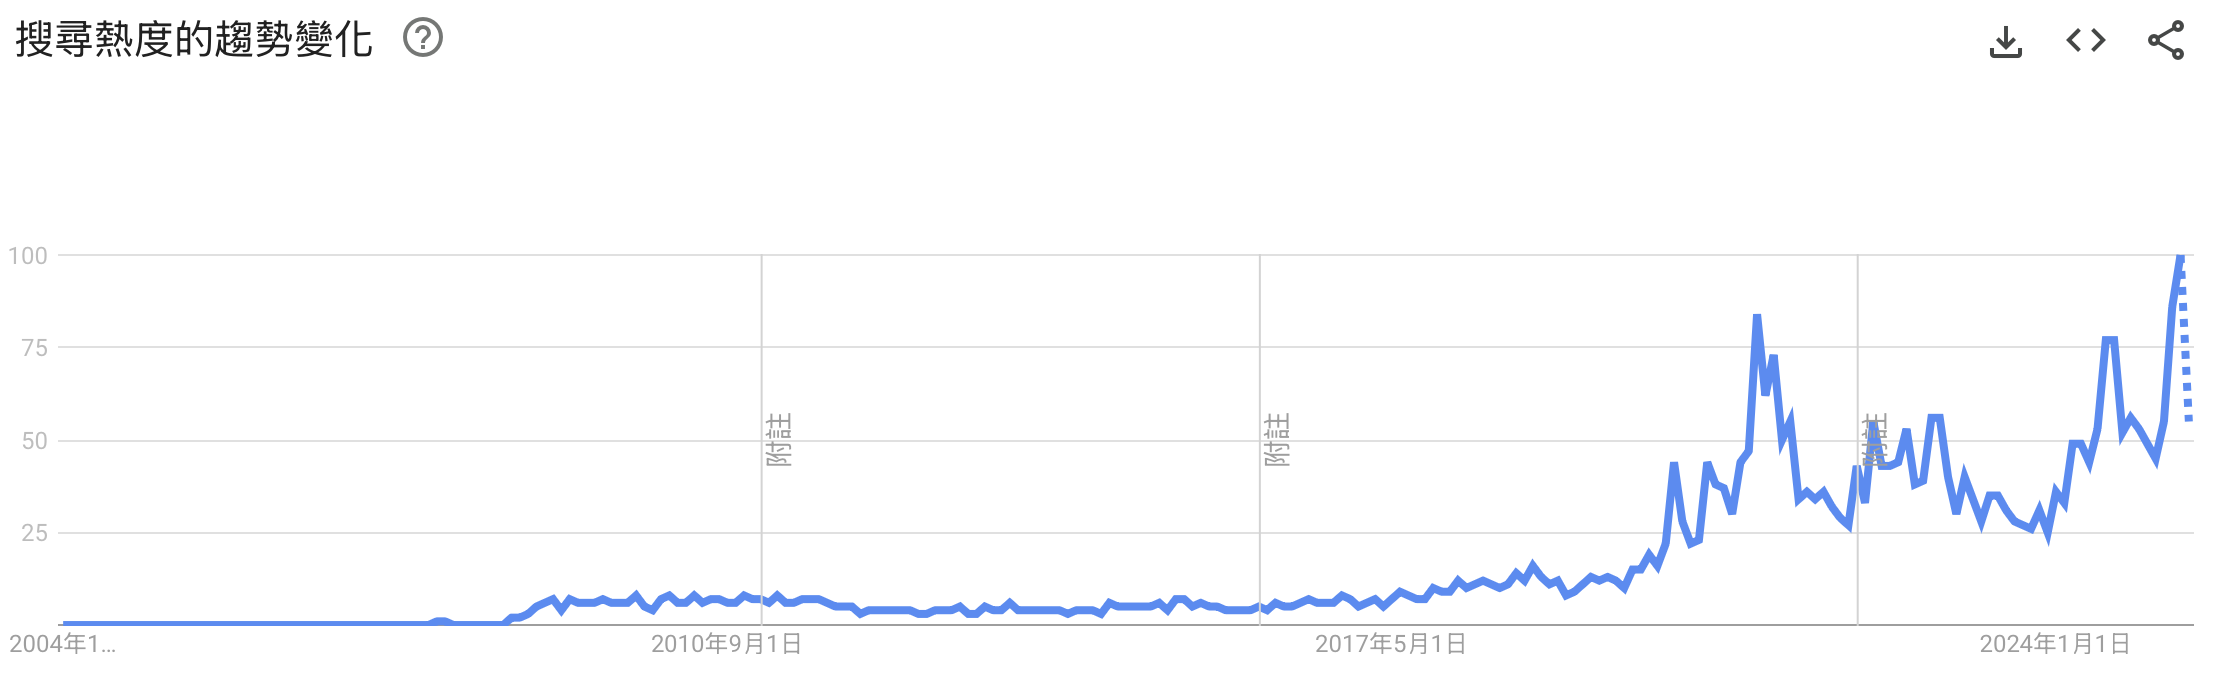

# 欄位更名

In [ ]:
column_map = work_list['symbol'].to_dict()
news_factor=every_day_df.rename(columns=column_map)